<a href="https://colab.research.google.com/github/iamnileshmehta/Deep-Learning-Projects/blob/main/Stock_price_prediction_using_LSTM_with_the_attention_mechanism_of_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Setting up the environment:

In [ ]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#tenserflow version
print('tf version', tf.__version__)

tf version 2.15.0


- Fetching the historical data:

In [ ]:
nifty = yf.download('^NSEI', period='6mo', interval='1d')
nifty.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-23,21716.699219,21750.250000,21192.599609,21238.800781,21238.800781,449700
2024-01-24,21185.250000,21482.349609,21137.199219,21453.949219,21453.949219,407500
2024-01-25,21454.599609,21459.000000,21247.050781,21352.599609,21352.599609,418100
2024-01-29,21433.099609,21763.250000,21429.599609,21737.599609,21737.599609,376700
2024-01-30,21775.750000,21813.050781,21501.800781,21522.099609,21522.099609,375100


In [ ]:
nifty = nifty.dropna(subset='Volume')

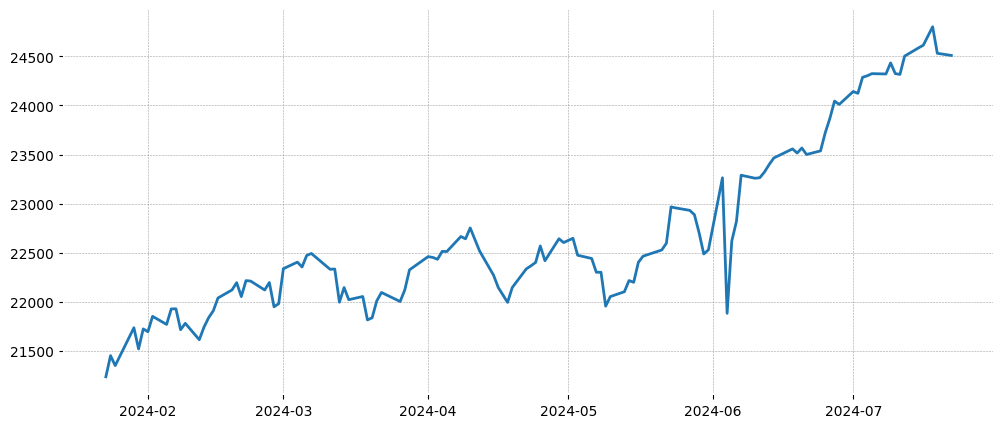

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(nifty['Close'])

Data preparation and clealing:

In [ ]:
nifty.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: >

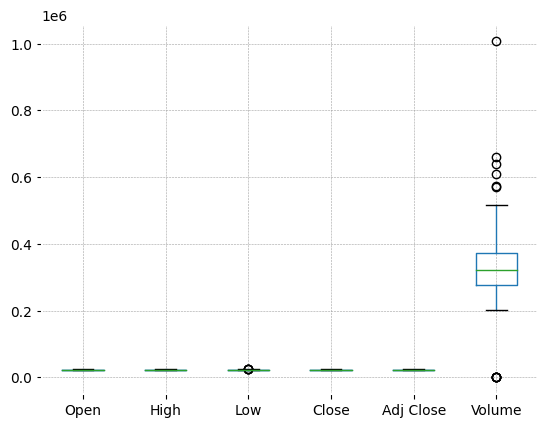

In [ ]:
nifty.boxplot()

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

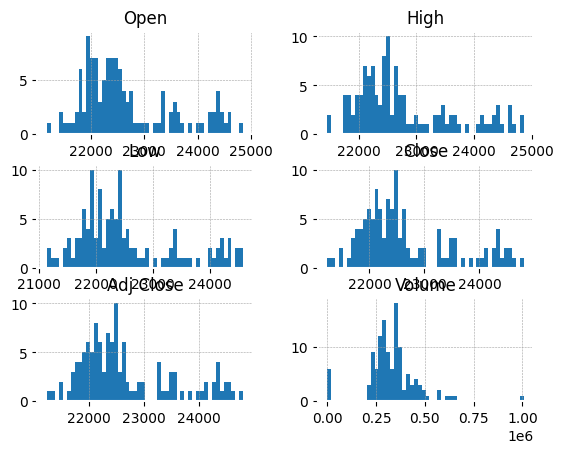

In [ ]:
nifty.hist(bins=50)

- Feature selection and Normalization:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
nifty_scaled = scaler.fit_transform(nifty['Close'].values.reshape(-1,1))

- Creating sequences:

In [ ]:
x= []
y= []

for i in range(60, len(nifty_scaled)):
  x.append(nifty_scaled[i-60:i,0])
  y.append(nifty_scaled[i,0])

- Train-test split:

In [ ]:
train_size = int(len(x)*0.8)
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


- Reshaping the data for LSTM:

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

- Creating the LSTM layers:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model= Sequential()

#adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=True))


- Integrating the Attention mechanism:

In [ ]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, x_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

- Optimizing the model:

In [ ]:
from keras.layers import BatchNormalization

#Adding Dropout and BatchNormalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

- Model compilation:

In [ ]:
model.compile(optimizer='adam', loss= 'mean_squared_error')

- Model summary:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute_6 (Permute)         (None, 50, 60)            0         
                                                                 
 reshape_6 (Reshape)         (None, 50, 60)            0         
                                                                 
 permute_7 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_7 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten_3 (Flatten)         (None, 3000)             

- Training the model:

In [ ]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(x_train, y_train, epochs=500, batch_size=25, validation_split=0.2)

Epoch 1/500
2/2 [==============================] - 5s 776ms/step - loss: 0.4546 - val_loss: 0.4443
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 0.5491 - val_loss: 0.5496
Epoch 3/500
2/2 [==============================] - 0s 37ms/step - loss: 0.2466 - val_loss: 0.6024
Epoch 4/500
2/2 [==============================] - 0s 41ms/step - loss: 0.2765 - val_loss: 0.5679
Epoch 5/500
2/2 [==============================] - 0s 34ms/step - loss: 0.2111 - val_loss: 0.5116
Epoch 6/500
2/2 [==============================] - 0s 34ms/step - loss: 0.2043 - val_loss: 0.4971
Epoch 7/500
2/2 [==============================] - 0s 34ms/step - loss: 0.2303 - val_loss: 0.5153
Epoch 8/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1787 - val_loss: 0.5425
Epoch 9/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1812 - val_loss: 0.5485
Epoch 10/500
2/2 [==============================] - 0s 47ms/step - loss: 0.1942 - val_loss: 0.5320
Epoch 11/500
2/2 [

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, epochs=500, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
2/2 [==============================] - 0s 142ms/step - loss: 0.0040 - val_loss: 0.0880
Epoch 2/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0051 - val_loss: 0.1132
Epoch 3/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0048 - val_loss: 0.1336
Epoch 4/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0066 - val_loss: 0.1196
Epoch 5/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0052 - val_loss: 0.1003
Epoch 6/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0040 - val_loss: 0.0869
Epoch 7/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0064 - val_loss: 0.0833
Epoch 8/500
2/2 [==============================] - 0s 68ms/step - loss: 0.0058 - val_loss: 0.0926
Epoch 9/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0049 - val_loss: 0.1010
Epoch 10/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0064 - val_loss: 0.0884
Epoch 11/500
2/2 [

- Evaluating Model Performance:

In [ ]:
# Convert X_test and y_test to Numpy arrays if they are not already
x_test = np.array(x_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(x_test, y_test)
print("Test Loss: ", test_loss)

1/1 [==============================] - 0s 25ms/step - loss: 0.5206
Test Loss:  0.5205584168434143


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(x_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

1/1 [==============================] - 1s 654ms/step
Mean Absolute Error:  0.6988984507197639
Root Mean Square Error:  0.7214973273796259


Predicting the Next 4 Candles:

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of nifty stock data
data = yf.download('^NSEI', period='6mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
Predicted Stock Prices for the next 4 days:  [21276.479, 21573.812, 21830.572, 21798.617]


- Visualization of Predictions:

In [ ]:
!pip install mplfinance -qqq

<Figure size 1200x800 with 0 Axes>

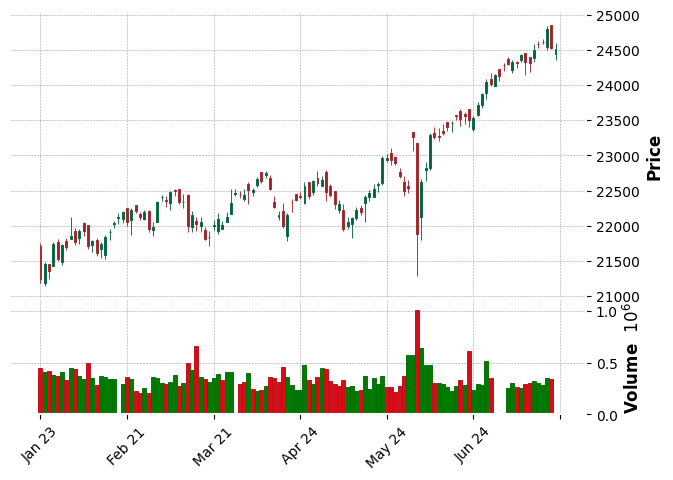

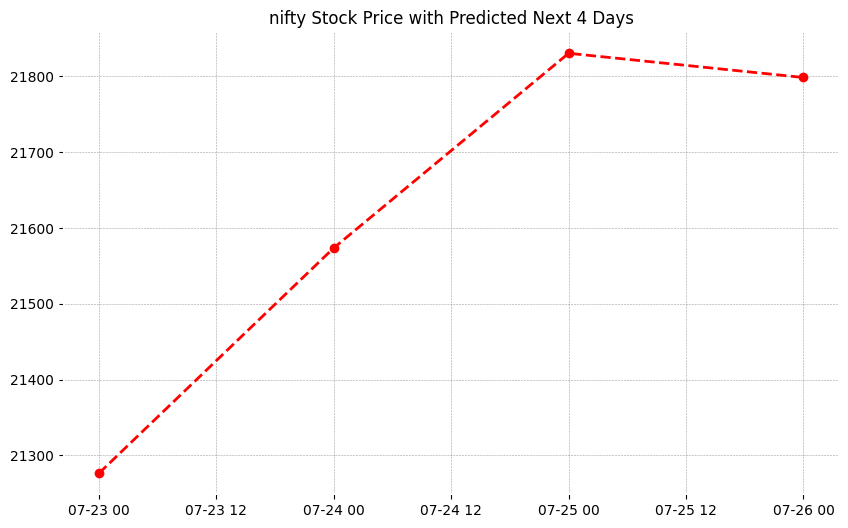

In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched nifty stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Open'])

# Plotting the actual data with mplfinance
plt.figure(figsize=(12,8))
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Open'], linestyle='dashed', marker='o', color='red')

plt.title("nifty Stock Price with Predicted Next 4 Days")
plt.show()

- Final prediction:

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


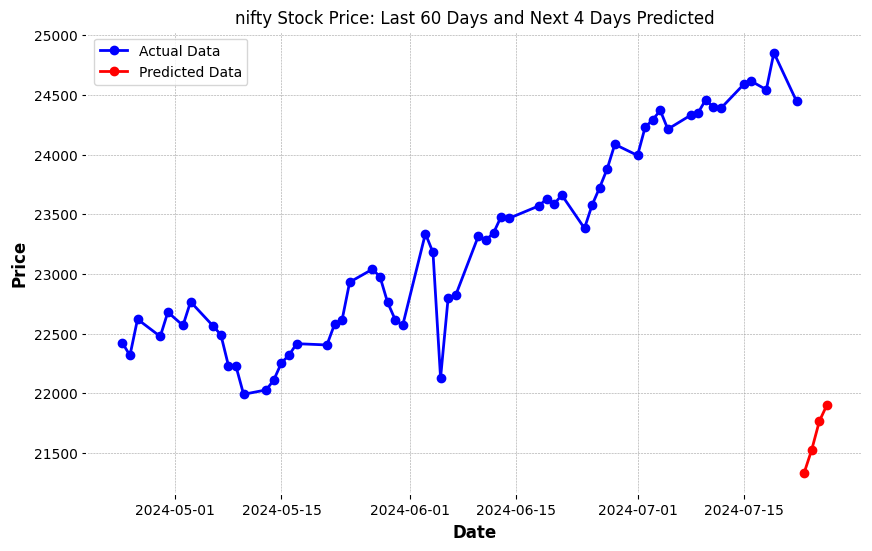

In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of nifty stock data
data = yf.download('^NSEI', period='6mo', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Open'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Open'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Open'], predicted_data['Open']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Open'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("nifty Stock Price: Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()